In [275]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from unet.networks.unet3d import UNet3D

In [283]:
import tensorboard

In [404]:
def build_data(data_size: int, data_shape: tuple, num_classes: int):
    assert len(data_shape) == 4, "data_shape must have shape (channels, depth, height, width)"
    channels, depth, height, width = data_shape
    torch.manual_seed(42)
    data_X = []
    data_y = []
    for i in range(data_size):
        # dtype float32 for input pixels
        data_X.append(
            np.random.rand(channels, depth, height, width).astype(np.float32)
        )
        # dtype int64 since class predictions are ints
        # max = 2 since randint requires it to be one above max. Unsure why
        data_y.append(
            np.random.randint(0, 2, (num_classes, depth, height, width)).astype(np.int64)
        )
    return data_X, data_y


o, t = build_data(3, (1, 10, 64, 64), 2)
len(o), len(t)

(3, 3)

In [4]:
# mp = nn.MaxPool3d(kernel_size=(1, 2, 2))
mp = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=2)
x = torch.randn(1, 3, 1024, 1024)
mp(x).shape

torch.Size([1, 1, 512, 512])

In [533]:
unet = UNet3D(input_channels=1, num_classes=2, dropout_probability=0.1, conv_kernel_size=3, activation="sigmoid")
img_shape = (1, 24, 64, 64)
x = torch.randn(1, *img_shape)
y = torch.randint(0, 2, (pred.shape), dtype=torch.long)
pred = unet(x)
x.shape, y.shape, pred.shape

(torch.Size([1, 1, 24, 64, 64]),
 torch.Size([1, 2, 24, 64, 64]),
 torch.Size([1, 2, 24, 64, 64]))

In [534]:
import sklearn.metrics

probability = pred.sigmoid().detach().numpy().flatten()[0:3]
y = y.long().detach().cpu().numpy().flatten()[0:3]

# roc = sklearn.metrics.roc_auc_score(y, probability, labels=[0, 1], multi_class="ovo")

# Convert probabilities into binary predictions
th_prediction = (probability > 0.5)

y[0:3], th_prediction[0:3], sklearn.metrics.precision_score(y, th_prediction), sklearn.metrics.recall_score(y, th_prediction)

(array([1, 0, 0]), array([ True,  True,  True]), 0.3333333333333333, 1.0)

So you have a two class problem. Your input GT mask has two one-hot encoded classes, the cell membrane and the cell center.

Questions: 
1. If using softmax activation, how do you translate these into multiclass readouts?
   1. How do you determine that a pixel is classified as one, but not the other?
      1. Argmax?
2. For sigmoid activation, you are assuming that some pixels can be multiple classes. Explore this. 


If you intend to use Cross Entropy Loss, it already includes a softmax, so it's likely a bad idea to include it in the model. 

I think that using sigmoid makes sense. Since you are predicting cell boundaries, they will overlap with one another. You'll perform watershed on them later. So, perform sigmoid on the outputs, then **threshold** the outputs with a value of **0.5**
   0.5 is used since it's a binary threshold problem and sigmoid scales between 0-1. If you were using softmax for 4 classes, the thresholds for each class would be (1/4), so 0.25 for each class. Ie. if a pixel was between 0-0.25, it'd be class 1, 0.25-0.5 is class 2 etc. 

We will predict two classes this way using sigmoid since we used the data augmentation to calculate cell edges and centers in a one-hot encoded manner (mask shape of (class, depth, height, width)). 

Try to take the maddox dataset and make it much, much smaller, just so we can run some local tests. 



In [626]:
# Two one-hot encoded 3d images with size 10x10x10
img_shape = (1, 10, 10, 10)
input_img = torch.randn(1, *img_shape)
gt_mask = np.zeros((2, 10, 10, 10))

gt_mask[0, 0:5, 0:5, 0:5] = 1
gt_mask[1, 5:, 5:, 5:] = 1

unet_none = UNet3D(input_channels=1, num_classes=3, network_depth=2, dropout_probability=0.1, conv_kernel_size=3, activation=None)
unet_sig = UNet3D(input_channels=1, num_classes=3, network_depth=2, dropout_probability=0.1, conv_kernel_size=3, activation="sigmoid")
unet_soft = UNet3D(input_channels=1, num_classes=3, network_depth=2, dropout_probability=0.1, conv_kernel_size=3, activation="softmax")

pred_none = unet_none(input_img).detach().numpy()[0,...]
pred_sig = unet_sig(input_img).detach().numpy()[0,...]
pred_soft = unet_soft(input_img).detach().numpy()[0,...]

In [629]:
pred_soft[0, 0, 0, 0:3], pred_soft[1, 0, 0, 0:3], pred_soft[2, 0, 0, 0:3]

(array([0.36745355, 0.28825787, 0.35672456], dtype=float32),
 array([0.37790936, 0.40899363, 0.35661   ], dtype=float32),
 array([0.25463706, 0.3027485 , 0.28666544], dtype=float32))

In [620]:
nn.Softmax(dim=None)(torch.tensor([0, 0.1, 0.2]))

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_71569/3590863840.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.Softmax(dim=None)(torch.tensor([0, 0.1, 0.2]))


tensor([0.3006, 0.3322, 0.3672])

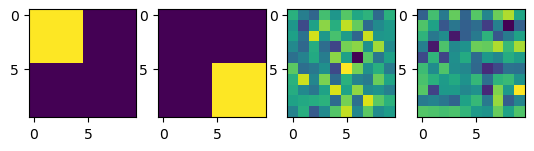

In [599]:
fig, ax = plt.subplots(1, 4)
ax[0].imshow(gt_mask[0,0,...])
ax[1].imshow(gt_mask[1,5,...])
ax[2].imshow(pred_sig[1,5,...])
ax[3].imshow(pred_soft[1,5,...])

In [600]:
pred_sig.flatten()[0:5], pred_soft.flatten()[0:5]

(array([0.5012746 , 0.53113014, 0.56106776, 0.46884644, 0.5585482 ],
       dtype=float32),
 array([0.41740853, 0.5848051 , 0.39384654, 0.59576803, 0.5523354 ],
       dtype=float32))

In [86]:
from unet.networks.unet3d import Encoder

encoder = Encoder()
# input image
# Input shape is (batch, channel, depth, height, width)
x = torch.randn(1, 1, 24, 128, 128)
ftrs = encoder(x)
for ftr in ftrs[::-1][1:]:
    print(ftr.shape)

torch.Size([1, 256, 6, 32, 32])
torch.Size([1, 128, 12, 64, 64])
torch.Size([1, 64, 24, 128, 128])


In [38]:
from unet.networks.unet3d import Decoder

decoder = Decoder()
# Input to the decoder does not have the batch dim, just channel
x = torch.randn(1, 512, 3, 16, 16)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 24, 128, 128])

In [24]:
# With square kernels and equal stride
m = nn.ConvTranspose3d(16, 33, kernel_size=2, stride=2)
# non-square kernels and unequal stride and with padding
# m = nn.ConvTranspose3d(16, 33, (3, 5, 2), stride=(2, 1, 1), padding=(0, 4, 2))
input = torch.randn(20, 16, 10, 50, 100)
m(input).shape


torch.Size([20, 33, 20, 100, 200])

In [ ]:
# Ensemble model training

import torch
import torch.nn as nn

# Define the number of models to use in the ensemble
num_models = 5

# Create a list to store the models
models = []

# Train each model
for i in range(num_models):
    # Create the model
    model = UNet3D(in_channels, out_channels)

    # Train the model
    model.train()  # Set the model to training mode
    # Use a loop to iterate over the training data, and pass the input through the model to compute the loss
    # and update the model weights using backpropagation and an optimizer
    ...

    # Add the trained model to the list
    models.append(model)

# At test time, to make predictions using the ensemble of models, you can do the following:

# Set all models to evaluation mode
for model in models:
    model.eval()

# Iterate over the test data
for input in test_data:
    # Create a list to store the predictions of each model
    model_predictions = []
    # Iterate over the models
    for model in models:
        # Compute the prediction for the current model
        prediction = model(input)
        # Add the prediction to the list
        model_predictions.append(prediction)
    # Combine the predictions of the individual models using an averaging or voting strategy
    ensemble_prediction = combine_predictions(model_predictions)
    # Use the ensemble prediction for evaluation or further processing
    ...


In [457]:
# Creating multichannel dice loss

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def dice_loss(self, prediction, target):
        # Make arrays 1D
        prediction = prediction.flatten()
        target = target.flatten()
        target = target.float()

        intersection = (prediction * target).sum()

        loss = 1 - 2 * (intersection) / (prediction.sum() + target.sum())
        return loss
    
    def forward(self, prediction, target):
        prediction = nn.Sigmoid()(prediction)

        dice = self.dice_loss(prediction, target)

        avg_channel_dice = 1. - torch.mean(dice)

        return avg_channel_dice
        # return dice

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, prediction, target):
        output = self.bce(prediction, target.float()) + self.dice(prediction, target)

        return output

torch.manual_seed(42)
x = torch.rand((2, 24, 128, 128))
y = torch.randint(0, 2, (2, 24, 128, 128))

# loss = DiceLoss()
loss_fn = BCEDiceLoss()

loss = loss_fn(x, y)

loss

tensor(1.2872)